#Analyzing the NYC subway dataset | Intro of Data Science
- Author:  Chi-Yuan Cheng (cyuancheng AT gmail DOT com) 
- Last updated: Feb 17th  2015

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

%matplotlib inline 
from ggplot import *
from pylab import *
import statsmodels.api as sm
import random
from datetime import datetime
import scipy.stats as ss
import seaborn as sns

from functions_nyc import *

##Introduction

The goal of this project is to understand New York City (NYC) subway riding patterns and explore whether we can use weather conditions to predict the ridership. According to Metro Transit Authority (MTA), the NYC subway system has 469 stations – the largest number of public transit subway stations of any system in the world. We can use data to help MTA take initiative to ensure safety and effective operation of NYC Subway by answering the following quesitons: 

1. Does the weather condition (particulay rainning) affect the ridership?
2. Can we predict the number of people entering the subway by using weather, or other factors, such as weeekday or time of the day?

##The key messages from this project

1. There are more people entering NYC Subway in rainy days than that in non-rainy days.
2. The hourly entries during the weekend are less busy than in the weekdays. 
3. The most busy hours on the weekend begin at 12pm and it reaches to its maximal level in the late afternoon (4pm-8pm). In contrast, the most busy hours in the weekdays are at 12pm and 8pm.
4. The majority of passengers for MYC subway is people who commute to work in New York City, not the tourist.

##Background

I analyzed the data taken from the turnstile of the NYC subway system, which looks like the following picture.

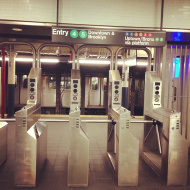

In [187]:
from IPython.display import Image
Image(filename='new-york-subway-turnstile.jpg')

The NYC subway and weather data on May 2011 was provided by Udacity. The original dataset can be found here:

* [NYC subway data](http://web.mta.info/developers/data/nyct/turnstile/turnstile_110507.txt)

* [NYC weather data](https://www.dropbox.com/s/7sf0yqc9ykpq3w8/weather_underground.csv)

Let's read data using Pandas and show an overview of our data.

In [203]:
df = pd.read_csv('data/turnstile_weather_v2.csv') # read data
df['Weekday'] = df['DATEn'].apply(lambda d: datetime.strptime(d, '%m-%d-%y').strftime('%A'))

print df.shape
df.head()

(42649, 28)


,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon,Weekday
0,R003,05-01-11,00:00:00,4388333,2911002,0,0,2011-05-01 00:00:00,0,6,...,0,55.9,3.5,0,30.258,55.98,7.86,40.700348,-73.887177,Sunday
1,R003,05-01-11,04:00:00,4388333,2911002,0,0,2011-05-01 04:00:00,4,6,...,0,52.0,3.5,0,30.258,55.98,7.86,40.700348,-73.887177,Sunday
2,R003,05-01-11,12:00:00,4388333,2911002,0,0,2011-05-01 12:00:00,12,6,...,0,62.1,6.9,0,30.258,55.98,7.86,40.700348,-73.887177,Sunday
3,R003,05-01-11,16:00:00,4388333,2911002,0,0,2011-05-01 16:00:00,16,6,...,0,57.9,15.0,0,30.258,55.98,7.86,40.700348,-73.887177,Sunday
4,R003,05-01-11,20:00:00,4388333,2911002,0,0,2011-05-01 20:00:00,20,6,...,0,52.0,10.4,0,30.258,55.98,7.86,40.700348,-73.887177,Sunday


The contains more than 42k rows of hourly entries in May 2011.
The dataset contains following properties:

NYC subway data

Property | Description
--- | ----
`UNIT` | Remote unit that collects turnstile information.
`DATEn` | Date in “mm-dd-yy” format
`TIMEn` | Time in “hh:mm:ss” format
`ENTRIESn` | Raw reading of cummulative turnstile entries from the remote unit. 
`EXITSn` | Raw reading of cummulative turnstile exits from the remote unit 
`ENTRIESn_hourly` | Difference in ENTRIES from the previous REGULAR reading
`EXITSn_hourly` | Difference in EXITS from the previous REGULAR reading
`datetime` | Date and time in “yyyy:mm:dd hh:mm:ss” forma
`hour` | Hour of the timestamp from TIMEn
`day_week` | Integer (0-6 Mon-Sun) corresponding to the day of the week
`weekday` | Indicator (0 or 1) if the date is a weekday (Mon-Fri)
￼￼￼￼￼`station` | Subway station corresponding to the remote unit
`latitude` | Latitude of the subway station corresponding to the remote unit
`longitude` | Longitude of the subway station corresponding to the remote unit

Weather data

Property | Description
--- | ----
`conds` | Categorical variable of the weather conditions (Clear, Cloudy etc.) for the time and location
`fog` | Indicator (0 or 1) if there was fog at the time and location
`precipi` | Precipitation in inches at the time and location 
`pressurei` | Barometric pressure in inches Hg at the time and location
`rain` | Indicator (0 or 1) if rain occurred within the calendar day at the location.
`tempi` | Temperature in °F at the time and location
`wspdi` | Wind speed in mph at the time and location
`meanprecipi` | Daily average of precipi for the location
`meanpressurei` | Daily average of pressurei for the location
`meantempi` | Daily average of tempi for the location
`meanwspdi` | Daily average of wspdi for the location
`weather_lat` | Latitude of the weather station the weather data is from
`weather_lon` | Longitude of the weather station the weather data is from


Next, I checked on the raw data and got a general sense of variables and their distribution. 

In [200]:
df.describe()

,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,hour,day_week,weekday,latitude,longitude,fog,...,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon,WeekdayN
count,4.264900e+04,4.264900e+04,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,...,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000
mean,2.812486e+07,1.986993e+07,1886.589955,1361.487866,10.046754,2.905719,0.714436,40.724647,-73.940364,0.009824,...,0.224741,63.103780,6.927872,0.004618,29.971096,63.103780,6.927872,40.728555,-73.938693,2.905719
std,3.043607e+07,2.028986e+07,2952.385585,2183.845409,6.938928,2.079231,0.451688,0.071650,0.059713,0.098631,...,0.417417,8.455597,4.510178,0.016344,0.131158,6.939011,3.179832,0.065420,0.059582,2.079231
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,40.576152,-74.073622,0.000000,...,0.000000,46.900000,0.000000,0.000000,29.590000,49.400000,0.000000,40.600204,-74.014870,0.000000
25%,1.039762e+07,7.613712e+06,274.000000,237.000000,4.000000,1.000000,0.000000,40.677107,-73.987342,0.000000,...,0.000000,57.000000,4.600000,0.000000,29.913333,58.283333,4.816667,40.688591,-73.985130,1.000000
50%,1.818389e+07,1.331609e+07,905.000000,664.000000,12.000000,3.000000,1.000000,40.717241,-73.953459,0.000000,...,0.000000,61.000000,6.900000,0.000000,29.958000,60.950000,6.166667,40.720570,-73.949150,3.000000
75%,3.263049e+07,2.393771e+07,2255.000000,1537.000000,16.000000,5.000000,1.000000,40.759123,-73.907733,0.000000,...,0.000000,69.100000,9.200000,0.000000,30.060000,67.466667,8.850000,40.755226,-73.912033,5.000000
max,2.357746e+08,1.493782e+08,32814.000000,34828.000000,20.000000,6.000000,1.000000,40.889185,-73.755383,1.000000,...,1.000000,86.000000,23.000000,0.157500,30.293333,79.800000,17.083333,40.862064,-73.694176,6.000000


##Approach
To explore the relationship between the subway ridership and weather conditions, I will:

1. Visualize the data to get a general idea of the paterns by weather type and time
2. Use statistics to determine whether the subway ridership is significant different between rainy days and non-rainy days
3. Build models to see how the ridership correlates with other factors

##Results and Discussion

###Section 1. Visualization

I first start with visulization to see hourly entries in rainy vs. non-rainy days

*1.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.*

>See Fig.1.

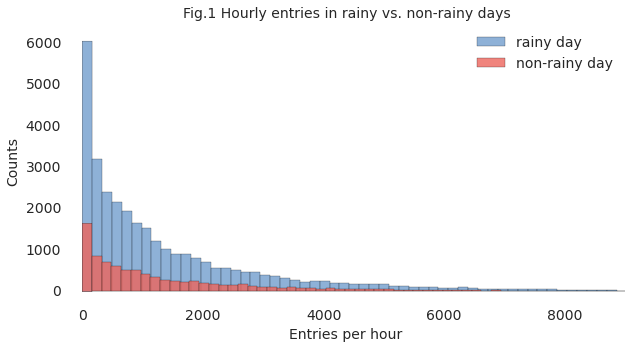

In [201]:
fig, ax = plt.subplots(figsize=(10, 5)) 

df.ENTRIESn_hourly[df.rain==0].hist(alpha=0.8,bins=200, facecolor='#729ECE') 
df.ENTRIESn_hourly[df.rain==1].hist(alpha=0.8,bins=200, facecolor='#ED665D')

plt.title('Fig.1 Hourly entries in rainy vs. non-rainy days', size=14)
plt.ylabel('Counts', size=14)
plt.xlabel('Entries per hour',size=14)
plt.axis((-250, 9000, -250, 6500))
plt.legend(['rainy day','non-rainy day'], fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

From the above histogram, we know that hourly entries in rainy and non-rainy days are **not normal distribution**, so we can not use t-test to analyize this data. This will be discussed in more detail later. 

*1.2 One visualization can be more freeform. Some suggestions are: Ridership by time-of-day, Ridership by day-of-week*

> (1) Ridership by days

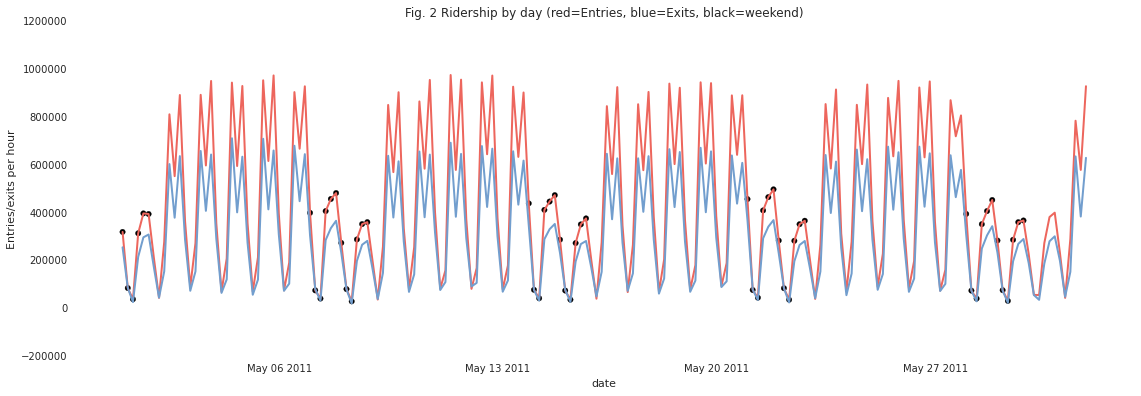

<ggplot: (293475989)>

In [192]:
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S") # convert string to pandas datetime

DatetimeEntriesExit = df[['datetime', 'ENTRIESn_hourly', 'EXITSn_hourly']].groupby('datetime', as_index=False).sum()
DatetimeEntries_weekend = df[['datetime', 'weekday','ENTRIESn_hourly']].groupby('datetime', as_index=False).sum()
ix_weekend = DatetimeEntries_weekend.datetime[DatetimeEntries_weekend ['weekday']==0].index.tolist() # find index on weekend
datetime_weekend = DatetimeEntries_weekend.datetime[DatetimeEntries_weekend ['weekday']==0] # find datetime on weekend
Entries_weekend = DatetimeEntries_weekend.iloc[ix_weekend]['ENTRIESn_hourly'] # find entries on weekend
 
ggplot(aes(x='datetime'), data = DatetimeEntriesExit) \
    + geom_line(aes(y='ENTRIESn_hourly'), color='#ED665D', size=2) \
    + geom_line(aes(y='EXITSn_hourly'), color='#729ECE', size=2)\
    + geom_point(aes(x='datetime_weekend', y='Entries_weekend'), data = DatetimeEntries_weekend, color='black', size = 30)\
    + ggtitle('Fig. 2 Ridership by day (red=Entries, blue=Exits, black=weekend)') \
    + ylab('Entries/exits per hour')+ xlab('date')+ theme_matplotlib(rc={"figure.figsize": "19, 6"}) 

>We can compare the numbers of hourly entries (red) and hourly exits (blue) aross all stations during May 2011 in Fig. 2. I used the black points to label the entries data on the weekend. The interesting findings were summarized below:
>* There are several spikes in both entries and exits in particular day/times. The data shows **the hourly entries during the weekend are less busy**, compared to the entries in the weekdays. One outlier is on Monday, May 30, which has less busy entries/exits. But it is Memorial day holiday.
>* Few people takes subway during the weekend and the Memorial holiday, suggesting that **the majority of passengers for NYC subway are commuters**.
>* It seems the entries/exits data has a specific pattern during a day in the weekdays. The patterns in the weekdays and on the weekend are quite differnet. We will see how the day of the week and the hour of the day affect the number of hourly entries/exits in next two figures.
>* **The total number of hourly entries and exits are very different.** It could be because people somehow bypass turntiles to exit. For example, the riders may use the emergency exits in major stations, such as 42nd St-Times Square.

In [202]:
print 'Total number of hourly entries = %s' %(df.ENTRIESn_hourly.sum()) 
print 'Total number of hourly exits = %s' %(df.EXITSn_hourly.sum())

Total number of hourly entries = 80461175.0
Total number of hourly exits = 58066096.0


>(2) Ridership by day-of-week

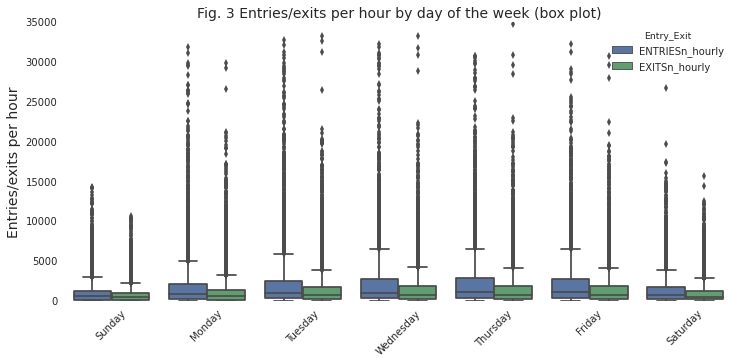

In [204]:
EntriesExitDay_raw = df[['day_week','ENTRIESn_hourly', 'EXITSn_hourly']]

# bulit new dataframe by pd.melt
EntriesExitDay_raw_melt = pd.melt(EntriesExitDay_raw, id_vars=['day_week'], \
                value_vars=['ENTRIESn_hourly', 'EXITSn_hourly'],\
         var_name='Entry_Exit', value_name='Value')

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x="day_week", y="Value", hue="Entry_Exit", data=EntriesExitDay_raw_melt);
plt.xlabel(' ')
plt.ylabel('Entries/exits per hour', size=14)
plt.title('Fig. 3 Entries/exits per hour by day of the week (box plot)',size=14)
ax.set_xticklabels(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],rotation=45)

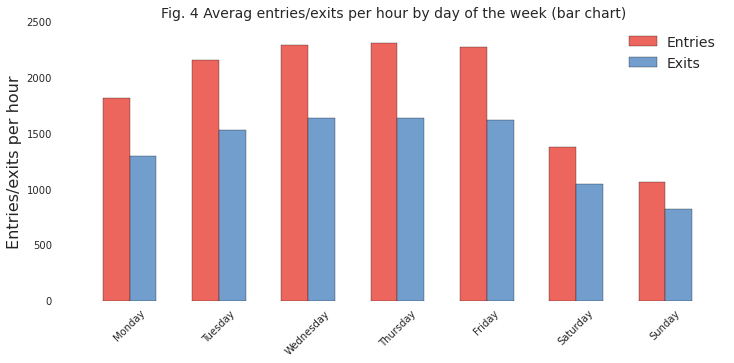

In [339]:
EntriesExitDay = df[['day_week','ENTRIESn_hourly', 'EXITSn_hourly']].groupby('day_week', as_index=False).mean()

fig, ax = plt.subplots(figsize=(12, 5))
width=0.3
rects1 = ax.bar(EntriesExitDay.day_week, EntriesExitDay.ENTRIESn_hourly, width, color='#ED665D')
rects2 = ax.bar(EntriesExitDay.day_week+width, EntriesExitDay.EXITSn_hourly, width, color='#729ECE')

plt.xlim(-0.5,7)
plt.ylabel('Entries/exits per hour', size=16)
plt.title('Fig. 4 Average entries/exits per hour by day of the week (bar chart)',size=14)
ax.set_xticks(EntriesExitDay.day_week+width)
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday",],rotation=45)
ax.legend(["Entries", "Exits"], fontsize=14)
plt.show()

>If we sum up the number of entries and exits by day of the week across all stations (Fig. 3, Fig. 4), I found that **Saturday and Sunday are the least busy days**. **Tuesday is the most busy day**. It may be because no school, no work on the weekends, so fewer people take subway.


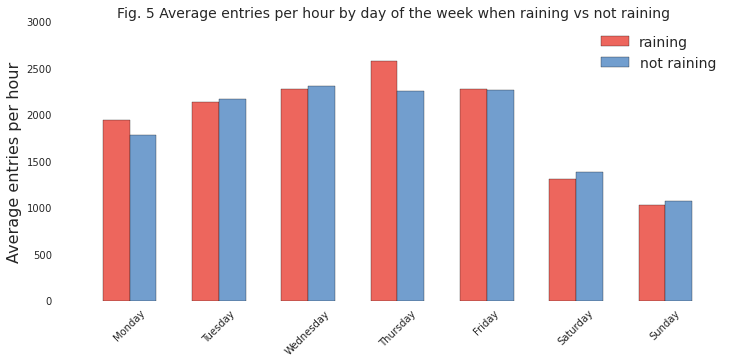

In [365]:
raining = df[df['rain'] == 1]
not_raining = df[df['rain'] == 0]

raining1 = raining[['day_week','ENTRIESn_hourly']].groupby('day_week', as_index=False).mean()
not_raining1 = not_raining[['day_week','ENTRIESn_hourly']].groupby('day_week', as_index=False).mean()

fig, ax = plt.subplots(figsize=(12, 5))
width=0.3

fig = ax.bar(raining1.day_week, raining1['ENTRIESn_hourly'], width, color='#ED665D')
fig = ax.bar(not_raining1.day_week+width, not_raining1['ENTRIESn_hourly'], width, color='#729ECE')

plt.xlim(-0.5,7)
plt.ylabel('Average entries per hour', size=16)
plt.title('Fig. 5 Average entries per hour by day of the week when raining vs not raining',size=14)
ax.set_xticks(EntriesExitDay.day_week+width)
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday",],rotation=45)
ax.legend(["raining", "not raining"], fontsize=14)
plt.show()

The above plots shows that the average entries value when it's raining has a week peak around Thursday and drop off in the weekend. This makes sense if you assume that the Subway is mainly used for commuting to and from work where most people work between the days Mon-Fri. There also seems to be a (slightly) higher average when raining compared not raining, esp. on Thursday.

>(3) Ridership by time-of-day

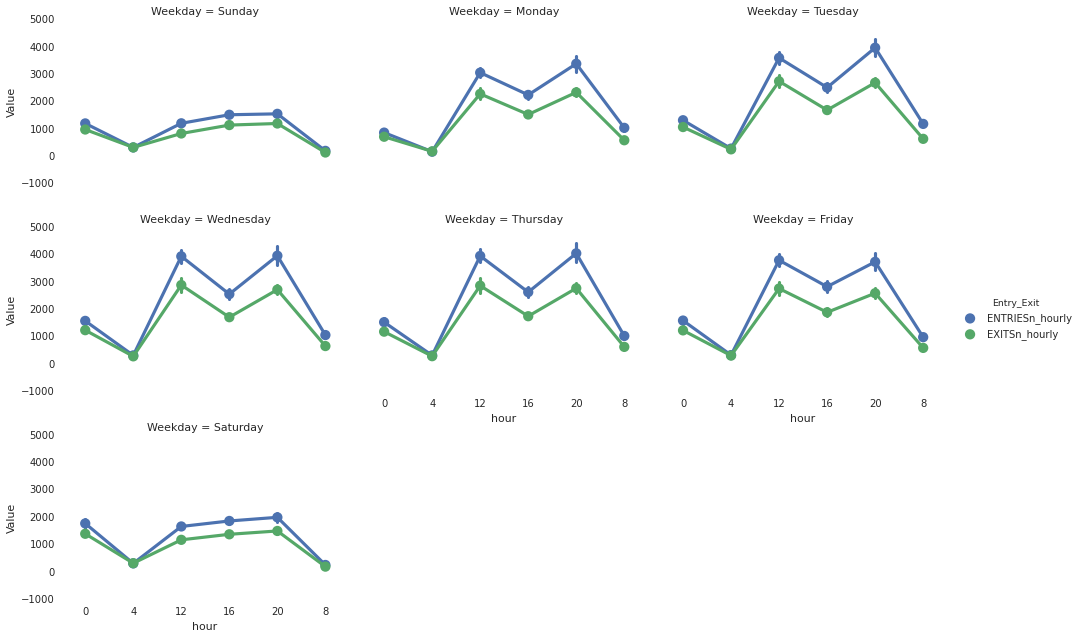

In [215]:
EntriesExit_weekday = df[['Weekday', 'hour', 'ENTRIESn_hourly', 'EXITSn_hourly']]
# bulit new dataframe by pd.melt
EntriesExit_weekday_melt = pd.melt(EntriesExit_weekday, id_vars=['Weekday', 'hour'], \
                value_vars=['ENTRIESn_hourly', 'EXITSn_hourly'],\
                var_name='Entry_Exit', value_name='Value')

sns_plot  = sns.factorplot(x="hour", y="Value", hue="Entry_Exit", col_wrap=3,
               col="Weekday", data=EntriesExit_weekday_melt, size=3, aspect=1.5);

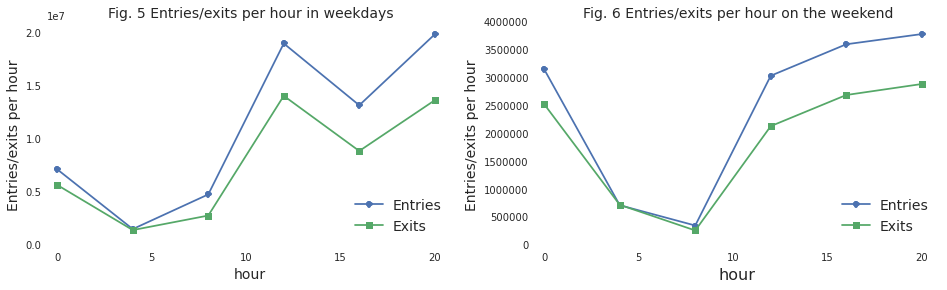

In [216]:
# weekend data
ix_weekend = df.hour[df['weekday']==0].index.tolist() # find index on weekend
hour_weekend  = df.hour[df['weekday']==0] # find datetime on weekend
Entries_weekend = df.iloc[ix_weekend]['ENTRIESn_hourly'] # find entries on weekend
Exits_weekend = df.iloc[ix_weekend]['EXITSn_hourly'] # find entries on weekend
A=pd.Series(hour_weekend, name='hour_weekend')
B=pd.Series(Entries_weekend, name='Entries_weekend')
C=pd.Series(Exits_weekend, name ='Exits_weekend')
data_weekend = pd.concat([A,B,C],axis=1)
data1_weekend=pd.DataFrame(data_weekend).groupby("hour_weekend", as_index=False).sum()

#weekday data
ix_weekday = df.hour[df['weekday']!=0].index.tolist() # find index on weekend
hour_weekday  = df.hour[df['weekday']!=0] # find datetime on weekday
Entries_weekday = df.iloc[ix_weekday]['ENTRIESn_hourly'] # find entries on weekday
Exits_weekday = df.iloc[ix_weekday]['EXITSn_hourly'] # find entries on weekday
D=pd.Series(hour_weekday , name='hour_weekday')
E=pd.Series(Entries_weekday , name='Entries_weekday')
F=pd.Series(Exits_weekday , name ='Exits_weekday')
data_weekday = pd.concat([D,E,F],axis=1)
data1_weekday=pd.DataFrame(data_weekday).groupby("hour_weekday", as_index=False).sum()

fig, ax = plt.subplots(figsize=(16, 4)) 
plt.subplot(121)
plt.plot(data1_weekday.hour_weekday, data1_weekday.Entries_weekday,'-o',\
         data1_weekday.hour_weekday, data1_weekday.Exits_weekday,'-s')
plt.xlabel("hour", size=14)
plt.ylabel("Entries/exits per hour",size=14)
plt.legend(["Entries", "Exits"],fontsize=14, loc=4)
plt.title("Fig. 5 Entries/exits per hour in weekdays",size=14)
plt.axis((-0.5, 21, 0, 2.1e7))
ax.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(122)
plt.plot(data1_weekend.hour_weekend, data1_weekend.Entries_weekend,'-o',\
         data1_weekend.hour_weekend, data1_weekend.Exits_weekend,'-s')
plt.xlabel("hour", size=16)
plt.ylabel("Entries/exits per hour",size=14)
plt.legend(["Entries", "Exits"],fontsize=14, loc=4)
plt.title("Fig. 6 Entries/exits per hour on the weekend",size=14)
plt.axis((-0.5, 21, 0, 0.4e7))
ax.tick_params(axis='both', which='major', labelsize=14)

>As mentioned previously, the hourly entries/exits data has a different pattern between the weekdays and the weekend. Here, I plot the total hourly entries and exits grouped by hour in the weekdays (Fig. 5) versus on the weekend (Fig. 6) to see which hours are more busy than others. The data suggest that the most busy hours are 12pm and 8pm in the weekdays, whereas the busy hours on the weekend begin at 12pm and it reaches to its maximul level in the afternoon (4pm-8pm). The busy hour on the weekend drops from 12am to 8am. **Overall, the total number of entries on the weekend is about a factor of 4.5 less than in the weekdays.**

>We know that the most busy hour is between 8am and 8pm (Fig. 5, and Fig. 6), and Tuesday is the most busy day for NYC subway (Fig. 4). These findings suggest that **the majority of passengers for NYC subway are commuters, not the tourists**. 

In [217]:
print 'Total number of hourly entries in the weekdays = %.0f' %(data1_weekday.Entries_weekday.sum()) 
print 'Total number of hourly entries on the weekend = %.0f' %(data1_weekend.Entries_weekend.sum())
print 'Total number of entries on the weekend is about a factor of %.1f less than in the weekdays\
'%(data1_weekday.Entries_weekday.sum()/data1_weekend.Entries_weekend.sum())

Total number of hourly entries in the weekdays = 65755562
Total number of hourly entries on the weekend = 14705613
Total number of entries on the weekend is about a factor of 4.5 less than in the weekdays


###Section 2. Statistical Test
*2.1 Which statistical test did you use to analyse the NYC subway data? Did you use a one-tail or a two-tail p value? What is the null hypothesis? What is your p-critical value?*

>I used two-tailed statistical test. **The null hypothesis is that the datasets of ridership in rainy and non-rainy days are identical.** The p-critical value is 0.025 for the probability distribution of a 95% confidence level.

*2.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.*

>I used the histograms to analyze the number of turnstile entries per hour (ENTRIESn_hourly) in rainy vs. non-rainy days (see Fig.1). The result shows it is not a normal distribution, so doing a Welch’s T-Test would not work well. The Mann-Whitney U-test is a non-parametric test, and does not assume any particular distribution. Therefore, the Mann-Whitney U-test is used to analysis the hourly entries data in the NYC subway dataset. 

*2.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.*

>Since the p-value returned from the U-test is < 0.025, we can reject the null hypothesis and imply the number of hourly entries is statistically different between rainy and non-rainy days.

In [218]:
# Mann Whitney U-test
U,p = scipy.stats.mannwhitneyu(df.ENTRIESn_hourly[df.rain==1], df.ENTRIESn_hourly[df.rain==0]) 
print 'U-value = %s' %(U)
print 'p-value = %.10f' %(p)

U-value = 153635120.5
p-value = 0.0000027411


*1.4 What is the significance and interpretation of these results?*

>**Besed on the U-test, we can conclude that the ridership is significantly different in rainy days vs. in non-rainy days.** We can further perform statistical analysis on the datasets of hourly entries in rainy and non-rainy day. The result is summarized in the table below. 

In [219]:
df_rain = df[["rain", "ENTRIESn_hourly"]]

# add a new column (category) to for no raining vs raining
df_rain["category"] = np.where(df_rain["rain"] == 1, "raining", "no_raining")
df_rain.groupby("category").describe()

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ENTRIESn_hourly   rain
category                                
no_raining count     33064.000000  33064
           mean       1845.539439      0
           std        2878.770848      0
           min           0.000000      0
           25%         269.000000      0
           50%         893.000000      0
           75%        2197.000000      0
           max       32814.000000      0
raining    count      9585.000000   9585
           mean       2028.196035      1
           std        3189.433373      0
           min           0.000000      1
           25%         295.000000      1
           50%         939.000000      1
           75%        2424.000000      1
           max       32289.000000      1

>Because the hourly entries data is not normal distributed, we will need to use the *median* instead of mean to compare the data between rainy and non-rainy days.

In [42]:
print "The median of hourly entries in raining days =%s" %(df_rain.ENTRIESn_hourly[df_rain["rain"] == 1].median())
print "The median of hourly entries in non-raining days = %s" %(df_rain.ENTRIESn_hourly[df_rain["rain"] == 0].median())

The median of hourly entries in raining days =939.0
The median of hourly entries in non-raining days = 893.0


>Based on the median values, we can conclude that **the number of hourly entries in rainy days is greater than that in non-rainy days.**

###Section 3. Modeling with Linear Regression
In the following, I will use machine learning to predict the ridership of NYC subway dataset.
####Machine Learning


We will examine the relationship between the cost function $J(\theta)$, the convergence of gradient descent, and the learning rate $\alpha$.

We will use the NYC subway/weather data as a training set, where the output $y^{(i)}$ **(values)** is the entries per hour (ENTRIESn_hourly) and the inputs $x^{(i)}$ **(features)** are the subway ridership and weather variables.

We first normalize the inputs $x^{(i)}$ by their standard deviations and set their means to zero.

Then, we introduce the gradient descent.
The hypothesis function is

$$
\begin{aligned}
h_{\theta}(x) =\theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n  &= \sum_{i=0}^n \theta_i x_i, \nonumber
\end{aligned}	 
$$

and the batch gradient descent update rule is

$$
\theta_j = \theta_j - \frac{\alpha}{m} \displaystyle \sum_{i=1}^{m} \left(h_{\theta}(x^{(i)}) - y^{(i)} \right ) x^{(i)}
$$

A good learning rate $\alpha$ is typilcally in the range of 
$$
0.001 \leq \alpha \leq 10 \nonumber
$$

We can make an initial selection, running gradient descent and observing the cost function, and adjusting the learning rate accordingly. The cost function is defined as

$$
\begin{aligned}
J(\theta) &= \frac{1}{2m} \displaystyle \sum_{i=1}^{m} \left( \textrm{predictions} - \textrm{actuals} \right) ^ 2 = \frac{1}{2m} \displaystyle \sum_{i=1}^{m} \left(h_{\theta}(x^{(i)}) - y^{(i)} \right) ^ 2
\end{aligned}
$$

We can now calculate $J(\theta)$ using the $\theta$ of the current stage of gradient descent. After stepping through many stages, we will see how $J(\theta)$ changes as the iterations advance.

*2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model?*

>I used the **Gradient Descent (GD)** and **Ordinary Least Squares (OLS)** models to do the linear regression on the NYC subway dataset:

*2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?*

>The features I uses were: 'rain','tempi', 'precipi'. The dummy variable I used is 'UNIT', 'hour', and 'weekday' for the both methods.

*2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model.*

>Feature selection:
1. For linear regression, it is better not to have features that include similar information. For instance, "day_week" and "weekday" contain similar information. 
2. I used dummy variables for the "UNIT" feature. Each station could have more than one unit (presumably more than one exit). On the other hands, the "UNIT" feature had all the inforamtion in the "station" feature. I also found that add "hour" and "weekday" as dummy variables can increase the $R^2$ value.
3. According to early statistical U-test analysis, more people would be willing to use subway when it's raining. Thus, I included 'rain' into the feature.
4. By playing with the features as a training dateset to the model, I found that these features ("rain", "tempi" "precipi") gives higher $R^2$ value in both models. I also played around with other parameters, but none of them were sensitive to the $R^2$ value. Another way to know which feature has an impact to the prediction is to determine their theta values ($\theta$) in the model. The theta value can point out which features add greater impact to the predicted value and the learning accuracy ($R^2$ value). 

**GD model**

I introduced the prediction functions for the GD model, and set $\alpha$=0.1 with 150 steps.

In [307]:
features = df[['rain','tempi', 'precipi']]

features = features.join((pd.get_dummies(df['UNIT'], prefix='unit').ix[:,1:]))
features = features.join((pd.get_dummies(df['hour'], prefix='hour').ix[:,1:]))
features = features.join((pd.get_dummies(df['weekday'], prefix='weekday').ix[:,1:]))

features, mu, sigma = normalize_features(features) # normalize feature values
features = np.array(features)
features = np.insert(features, 0, 1, axis=1) # add initial value (x)
values =  df['ENTRIESn_hourly'] 
theta_GD, pred_GD = predictions_GD(features=np.array(features),
                   values=values,
                   alpha=0.1,
                   num_iterations=150)

#make a new dataframe included predictions
predict_df = df[["UNIT", "datetime", "ENTRIESn_hourly"]].join(pd.Series(pred_GD, name="pred_GD"))
predict_df.head(5)

,UNIT,datetime,ENTRIESn_hourly,pred_GD
0,R003,2011-05-01 00:00:00,0,707.857865
1,R003,2011-05-01 04:00:00,0,0.000000
2,R003,2011-05-01 12:00:00,0,2295.751974
3,R003,2011-05-01 16:00:00,0,1645.173521
4,R003,2011-05-01 20:00:00,0,2576.734310


In [316]:
#print the first four values in theta_GD
print theta_GD[:3]
print "R^2 =", compute_r_squared(df["ENTRIESn_hourly"], pred_GD)

[ 1886.58969696    -1.92003814  -109.33148236]
R^2 = 0.559464930144


**OLS model**

I have used the same features: "'rain','tempi', 'precipi', 'UNIT', 'hour', 'weekday'. The last three are dummy variables.

In [309]:
# First, take numerical features and normalize them
features = df[['rain','tempi', 'precipi']]
features, mean, std_devs = normalize_features(features)

numNumericalFeatures = 4

# Add dummy variables (dropping 1 column to avoid multicollinearity, because we will include a constant term)
features = features.join((pd.get_dummies(df['UNIT'], prefix='unit').ix[:,1:]))
features = features.join((pd.get_dummies(df['hour'], prefix='hour').ix[:,1:]))
features = features.join((pd.get_dummies(df['weekday'], prefix='weekday').ix[:,1:]))

# Set the dependent variable
values = df['ENTRIESn_hourly']

Calculate $R^2$ value using sklearn

In [315]:
from sklearn.cross_validation import train_test_split

trainF, testF, trainV, testV = train_test_split(
    features, values, test_size=0.30, random_state=0)

from sklearn import linear_model

linear_reg = linear_model.LinearRegression()
linear_reg.fit(trainF, trainV)

from sklearn.metrics import accuracy_score

print "Coefficient of Determination (R^2) for OLS model = ", linear_reg.score(testF, testV)

Coefficient of Determination (R^2) for OLS model =  0.543556908567


The params for the non-dummy features, before recovering them from normalization, are:

In [314]:
model = sm.OLS(trainV, sm.add_constant(trainF)).fit() # Fit the model, adding a constant value
intercept = model.params[0]
params = model.params[1:]
params[0:numNumericalFeatures-1]

rain       -10.862774
tempi     -125.271408
precipi    -33.563842
dtype: float64

*2.4 What are the coefficients (or weights) of the non-dummy features in your linear regression model?*
> The coefficients ($\theta$) of the non-dummy features in the GD model are listed below.

>feature | $\theta$ (GD) | $\theta$ (OLS) 
--- | ---- 
`rain` | 1886.59 | -10.86
`tempi` | -1.92 | -125.27
`precipi` | -109.33 | -33.56

*2.5 What is your model’s R2 (coefficients of determination) value?*

>To evaluate how good these predictions are, we introduce the **coefficient of determination**, which measure the variability of the model. It varies from 0 to 1 and a larger value indicates a better fit.

>$$
\begin{aligned}
R^2 &= 1 - \frac{ \displaystyle \sum_{i=1}^{m} \left( y_i - f_i \right)^2 }{ \displaystyle \sum_{i=1}^{m} \left( y_i - \bar{y}_i \right)^2 }
\end{aligned}
$$

In [317]:
pred_OLS_train = getPredictions(trainF, intercept, params)
pred_OLS_test = getPredictions(testF, intercept, params)

print "R^2 for the GD model is %.3f." % (compute_r_squared(df["ENTRIESn_hourly"], pred_GD))
print "R^2 for the OLS model (training set) is %.3f." % (compute_r_squared(trainV, pred_OLS_train))
print "R^2 for the OLS model (test set) is %.3f." % (compute_r_squared(testV, pred_OLS_test))

R^2 for the GD model is 0.559.
R^2 for the OLS model (training set) is 0.540.
R^2 for the OLS model (test set) is 0.544.


The performance of GD model is slightly better than that of OLS model. In OLS model, The R^2 values are very similar between test and training sets, so we can say that OLS model does not have an overfitting problem

*2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?*

>The $R^2$ value for the GD model is 0.559 for the OLS model, which means that the model has explained 55.9% of the original variability and are left with 44.1% of the residual variability. Based on the high $R^2$ value, I think the OLS model is appropriate to predict the ridership for the NYC subway dataset. 

We can also plot the residuals between actual and predicted values to determine how good a statistical model is. A residual plot of a good model will be distributed as a normal distribution with a mean of 0 and some finite variances, as shown in Fig.7 for the GD model.

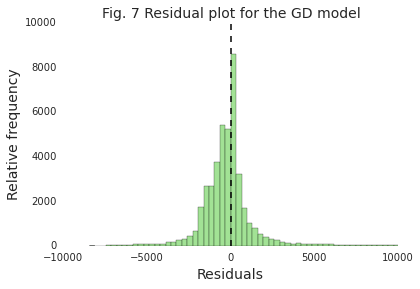

In [321]:
def plot_residuals(values, predictions):
    """
    Plot the error distribution (residuals): difference between the real value and the predicted value.
    """
    plt.figure(figsize=(10, 5))
    pd.DataFrame((values - predictions)).hist(bins = 100, alpha = 0.9, color='#98DF8A')
    plt.plot([0, 0], [0, 10000], 'k--', lw=1.5) # draw vertical line 
    plt.axis((-10000, 10000, 0, 10000))
    plt.xlabel('Residuals', size=14)
    plt.ylabel('Relative frequency', size=14)
    plt.title("Fig. 7 Residual plot for the GD model", size=14)
    return plt

plot_residuals(df["ENTRIESn_hourly"], pred_GD).show()

But there is a problem, which it is not easy to find. The histogram has a very large right tail. This indicates very large values for some residuals. We can use a Q-Q plot to check if the quantiles of our residuals distribution are similar to those from a standard normal distribution:

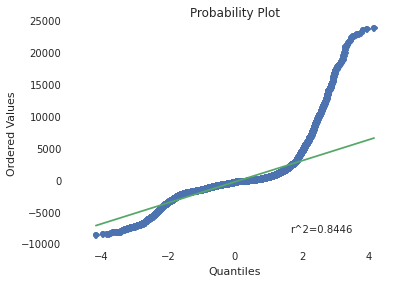

In [322]:
probplot = ss.probplot(df["ENTRIESn_hourly"] - pred_GD, plot=plt)

We can see that the adjustment is not perfect for bottom quantiles, but the big problem is in the upper quantiles. If we plot the values of the dependent variable (ENTRIESn_hourly) with their corresponding absolute residual, we can appreciate big deviations toward the larger values:

###Plotting the real data and predicted values
To compare the predicted values with the real data using the GD model, I plot both of them below:

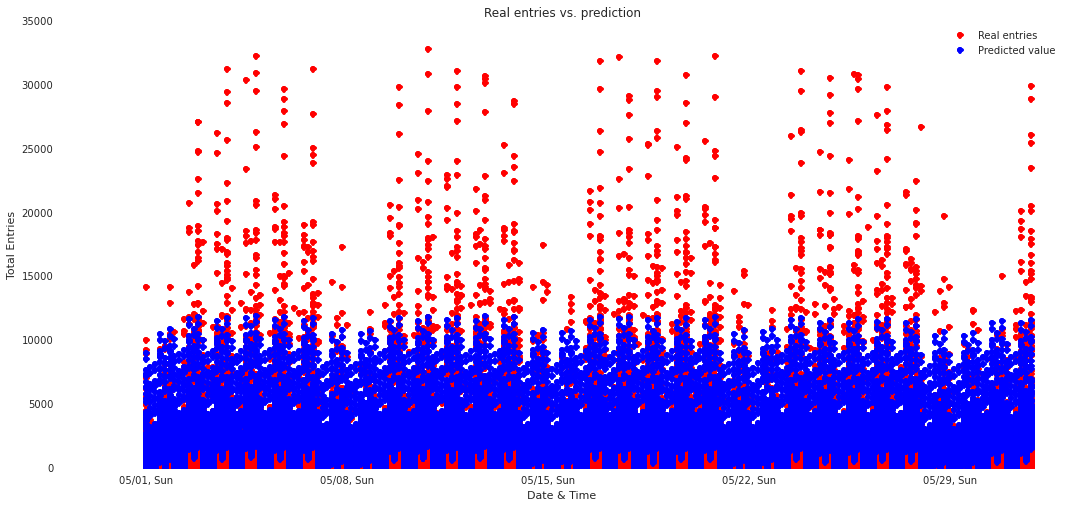

In [329]:
df['DATEn_TIMEn2'] = df['DATEn'] + " " + df['TIMEn']
new_x = df['DATEn_TIMEn2'].apply(lambda d: mdates.datestr2num(d))

predicted = pred_GD
fig = plt.figure()
fig.set_size_inches(18,8)
ax = fig.add_subplot(111)
plot1 = ax.plot(new_x, df['ENTRIESn_hourly'], 'ro')#, markersize=5)
plot2 = ax.plot(new_x,predicted, 'bo')#, markersize=5)

ax.set_ylabel('Total Entries')
ax.set_xlabel('Date & Time')
ax.set_title('Real entries vs. prediction')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(SU))
myFmt = mdates.DateFormatter('%m/%d, %a')
ax.xaxis.set_major_formatter(myFmt)
ax.legend((plot1[0], plot2[0]), ('Real entries','Predicted value'))
plt.show()

From the above graph, it looks like the predicted values (blue dots) are able to emulate the volitility by hours in a given day. However, the GD model consistenly underpredicts the peak entries. Based on the distribution of the residuals and QQ plot shown in FigX, the residual are unlikely to comre from a normal distribution. It means that the GD model is biased and needs to improve. The current dataset only contains weather inforamtion, time value, and turnstile, it would be great if we can have more inforation, such as street condition or whether there is big construction work near the subway stations, to help improve the model.

In [403]:
def prepare_data(filename):
    import pandas as pd
    import pandasql
    import matplotlib.colors as colors
    
    df = pd.read_csv(filename)
    query = '''
            SELECT station, latitude, longitude, hour,
                sum(EXITSn_hourly) as exits, sum(ENTRIESn_hourly) as entries
            FROM df
            WHERE weekday == 1
            GROUP BY station, hour
            '''
    sht = pandasql.sqldf(query.lower(), locals())
    # traffic describes total traffic at a turnstile by adding up exits and entries
    traffic = sht.exits + sht.entries
    # net_flow is the difference between exits and entries, normalized by traffic
    net_flow = (sht.exits - sht.entries) / traffic
    # clip bottom and top .03 quantile to remove outliers
    traffic = traffic.clip(traffic.quantile(.03), traffic.quantile(.97))
    net_flow = net_flow.clip(net_flow.quantile(.03), net_flow.quantile(.97))
    # normalize values (0 to 1 for net_flow, 20 to 480 for traffic)
    norm = colors.Normalize(net_flow.min(), net_flow.max())
    sht['net_flow'] = norm(net_flow)
    norm = colors.Normalize(traffic.min(), traffic.max())
    sht['traffic'] = norm(traffic) * 100 + 0
    return sht

def transform_coordinates(series, old_origin, old_width, new_origin, new_width):
    old_origin = float(old_origin)
    old_width = float(old_width)
    new_origin = float(new_origin)
    new_width = float(new_width)
    return new_origin + (series - old_origin) / old_width * new_width

def save_plot(df, hour, time):
    import matplotlib.pyplot as plt
    import matplotlib.lines as lines
    # load map image and calculate dimensions
    img = plt.imread('new-york.png')
    ypixels, xpixels, bands = img.shape
    dpi = 72.
    xinch = xpixels / dpi
    yinch = ypixels / dpi
    fig = plt.figure(figsize=(xinch*1./3., yinch * 1. /3.))
    plt.axes([0., 0., 1., .9], frameon=False, xticks=[], yticks=[])
    # plot background image with map
    plt.imshow(img, interpolation='none')
    # transform lat/lon to pixel coordinates
    xpos = transform_coordinates(df.longitude, -74.1, .35, 0, xpixels)
    ypos = transform_coordinates(df.latitude, 40.55, .35, ypixels, -ypixels)
    # draw scatter plot and make sure it's limited to the map dimensions
    plt.scatter(x = xpos, y = ypos, s = df.traffic, c = df.net_flow, 
            cmap = 'RdYlGn', linewidths= 0, alpha=0.7)
    plt.xlim(0, xpixels)
    plt.ylim(ypixels, 0)
    # add title and legend to plot
    fig.suptitle('New York Subway Usage (' + time + ')', fontsize=12)
    dot1 = lines.Line2D([0], [0], c='white', marker='o', mfc='green', ms=12, mew=0)
    dot2 = lines.Line2D([0], [0], c='white', marker='o', mfc='red', ms=12, mew=0)
    plt.legend([dot1, dot2],
            ['More people arriving than leaving',
             'More people leaving than arriving'],
            numpoints=1, loc='upper left')
    # save plot
    plt.savefig('turnstile_map_' + str(hour) + '.png', dpi=dpi)

In [380]:
df1 = prepare_data('data/turnstile_weather_v2.csv')
df1.head()

,station,latitude,longitude,hour,exits,entries,net_flow,traffic
0,1 AVE,40.730901,-73.981719,0,72055,75171,0.570339,169.160041
1,1 AVE,40.730901,-73.981719,4,10439,17308,0.404357,45.411054
2,1 AVE,40.730901,-73.981719,8,32655,17669,0.804183,68.794920
3,1 AVE,40.730901,-73.981719,12,136093,115945,0.644465,277.717854
4,1 AVE,40.730901,-73.981719,16,78652,91710,0.529660,193.122885


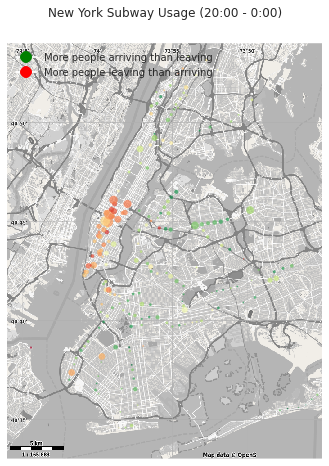

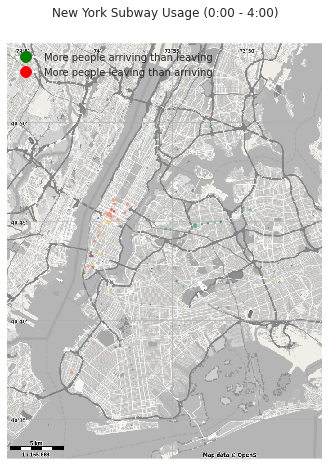

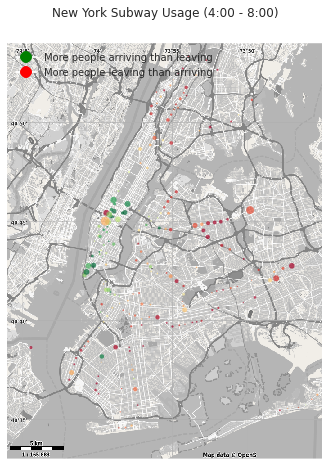

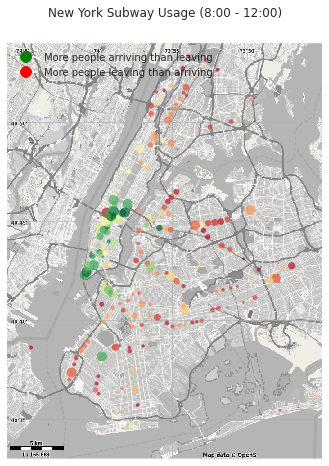

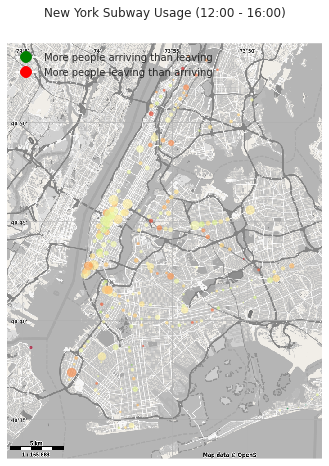

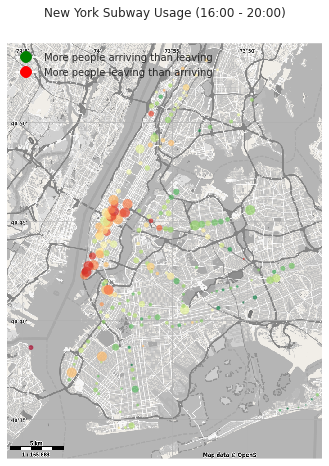

In [404]:
for hour in [0, 4, 8, 12, 16, 20]:
    timeframe = str((hour+20) % 24) + ':00 - ' + str(hour) + ':00'
    save_plot(df1[df1.hour == hour].reset_index(), hour, timeframe)

###Section 4. Conclusion

*4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?*
>Based on the data analysis, we can conclude that **more people ride the NYC subway when it is raining**. 

*4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.*
>There are about 46 more people ride the NYC system in a rainy day, compared to a non-rainy day. This conclusion is made based on the Mann Whitney U-test and the median values of the hourly entries in the rainy day vs. non-rainy day. Additionally, in the GD model, the feature of rain has a greater theta ($\theta$) value of 1886.6. These findings suggest that rain has a greater impacts on the hourly entries of NYC subway systems.


###Section 5. Reflection

5.1 Please discuss potential shortcomings of the methods of your analysis, including:
		Dataset,
		Linear regression model,
		Statistical test.
>Firstly, the possible shortcomings of the dataset is that the entries data only record every four hours, and the data were only recorded during May 2011. Secondly, the weather dataset was recorded by day. To make the data more percise, the weather data should be recorded by hour and by location. Although the linear regression gives a good fit to our dataset, one could make a complex model or feed in more features or more month logged data to improve the accuracy of the prediction.

###Reference

* [Mann-Whitney U-Test](https://explorable.com/mann-whitney-u-test)
* [R-square](http://www.statsoft.com/Textbook/Multiple-Regression#cresidual)
* Python for Data Analysis, by Wes McKinney, O'Reilly Media, 2012. 